# 2 практическое задание. Сегментация изображений.

## Практикум на ЭВМ для 317 группы, весна 2019

#### Фамилия, имя: 

Дата выдачи: 21 марта

Мягкий дедлайн: 30 марта 23:59 

В этом задании вы будете решать задачу сегментации людей на фотографии с помощью нейросетевых архитектур Unet и Linknet.

## Загрузка данных (1 балл)

Для загрузки данных pytorch опирается на такую сущность, как **`Dataset`**.

Этот абстрактный класс определен в `torch.utils.data.dataset`:

```python
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])
```
При определении нового источника данных мы создаем наследника данного класса и реализуем методы `__getitem__` и `__len__`.

Пример готового такого класса — `torchvision.datasets.ImageFolder`, который позволяет создать датасет на основе директории с imagenet-подобной структурой поддиректорий (`./train/{class}` и `./val/{class}`):

```python
imagenet = torchvision.datasets.ImageFolder('path/to/imagenet_root/')
```

Реализуйте класс PhotosDataset для выданных данных.

**Внимание.** Возможно, стоит прочитать следующий пункт задания, чтобы реализация была удобной.

In [0]:
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import dataset
from torch.utils.data.dataloader import DataLoader

from skimage import io

from PIL import Image, ImageEnhance
import PIL

import matplotlib.pyplot as plt
import numpy as np
import numpy.testing as npt

In [0]:
import os
import random

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
class PhotosDataset(dataset.Dataset):
    default_target_dir_name = 'data/train_mask/'
    
    def __init__(self, images_dir='data/train/', target_dir=None, _transforms=None, probability_transform=0.3):
        """
        Arguments
        ---------
        images_dir : str
            Path to directory with images
            
        images_names : list of str
            Images short names
            
        target_dir : str
            Path to directory with masks.
            Each mask corresponds to one image.
            Corresponding mask and image have the same name.
            
        transforms : some collection
            Sequence of transformations for images and masks. 
        """
        self.images_dir = images_dir
        self._transforms = _transforms
        
        if target_dir is None:
            self.target_dir = PhotosDataset.default_target_dir_name
        else:
            self.target_dir = target_dir
        
        self.probability_transform = probability_transform
        self.images_names = os.listdir(images_dir) 
        self.len = len(self.images_names)
    
    def __len__(self):
        return self.len
                   
    def __getitem__(self, idx):
        """
        Arguments
        ---------
        idx : int
            Index of image and mask
        
        Returns
        -------
        (image, mask)
        """
        name = self.images_names[idx]
        path_image = self.images_dir + name
        name = name[:-3] + "png"
        
        path_target = self.target_dir + name
        
        img = Image.open(path_image)
        mask = Image.open(path_target)
        
        if self._transforms is None:
            return img, mask
        
        for transform in self._transforms:
            if type(transform) == transforms.ToTensor:
                img = transform(img)
                mask = transform(mask)
            
            elif type(transform) == transforms.Normalize:
                img = transform(img)
                            
            else:
                if random.random() < self.probability_transform:
                    transform.method = 1
                    img, mask = transform(img, mask)
        
        
        
        return img, mask

In [0]:
class ChangeBrightness(object):
    def __init__(self, mode=0):
        self.method = mode

    def __call__(self, img, mask):
        if self.method:
            brigh = random.uniform(0.5, 1)
            return ImageEnhance.Brightness(img).enhance(brigh), mask
        return img, mask

In [0]:
class HorizontalFlip(object):
    def __init__(self, mode=0):
        self.method = mode

    def __call__(self, img, mask):
        if self.method:
            return img.transpose(Image.FLIP_LEFT_RIGHT), mask.transpose(Image.FLIP_LEFT_RIGHT)
        return img, mask

In [0]:
class ChangeBackground(object):
    def __init__(self, mode=0, backgrounds_path='backgrounds/'):
        self.method = mode
        self.backgrounds_path = backgrounds_path
        
        
    def __call__(self, img, mask):
        if self.method:
            backgrounds = os.listdir(self.backgrounds_path)
            rnd_background = Image.open(
                self.backgrounds_path + random.choice(backgrounds))
            
            new_img = Image.composite(img, rnd_background, mask) 
            return new_img, mask
        return img, mask

In [0]:
class CropCenterMask(object):
    def __init__(self, mode=0):
        self.method = mode

    def __call__(self, img, mask):
        if self.method:
            to_tensor = transforms.ToTensor()
            mask_np = to_tensor(mask).numpy().squeeze()
            mask_center = np.round(np.argwhere(mask_np==1).mean(axis=0)).astype(int)
            
            mask_center[0] = 320 - mask_center[0]
            
            top = random.randint(-150, -100) + mask_center[0]
            bottom = random.randint(100, 150) + mask_center[0]
            right = random.randint(60, 120) + mask_center[1]
            left = random.randint(-120, -70) + mask_center[1]

            top = max(0, top)
            right = min(240, right)
            
            bottom = min(320, bottom)
            left = max(0, left)
            return img.crop((left, top, right, bottom)).resize((240, 320)), \
                mask.crop((left, top, right, bottom)).resize((240, 320))
        
        return img, mask

## Модуль аугментации (3 балла)

Конструктор стандартного `ImageFolder`, принимают параметр `transform` (и иногда `target_transform`).

Они служат для того, чтобы загружаемые изображения (обычно это `PIL.Image`) или таргеты преобразовывать в тензоры нужного вида.

В `torchvision` входит модуль `transforms` для стандартных примеров таких преобразований. В `transforms` могут содержаться случайные преобразования, это самый простой путь для реализации аугментации данных.

При определении кастомного трансформера помимо конструктора нужно реализовать лишь метод `__call__`:

```python
class HorizontalFlip(object):
    def __init__(self, mode=0):
        self.method = mode

    def __call__(self, img):
        """
        Args:
            img (PIL.Image): Image to be flipped.

        Returns:
            PIL.Image: Randomly flipped image.
        """
        if self.method:
            return img.transpose(Image.FLIP_LEFT_RIGHT)
        return img

```

С полным списком стандартных преобразований можно ознакомиться в http://pytorch.org/docs/master/torchvision/transforms.html.

В данной части вам предлагается самостояльно реализовать несколько кастомных трансформеров.
Обратите внимание, что для некоторых трансформеров, необходимо преобразовывать и изображение, и маску, а для каких-то только изображение.

Один из путей реализации:
* реализовать декоратор, делающий любое преобразование случайным
* реализовать декоратор, применяющий преобразование и к изображению, и к маске

Список трансформеров, которые надо реализовать:

* случайное (с вероятностью p) горизонтальное отображение (flip) изображения 
* случайное (с веротностью p) вырезание фрагмента изображения (заданного или случайного размера)
* случайное (с вероятностью p) изменение яркости изображения (на заданную или случайную величину)
* случайное (с веротностью p) изменение фона изображения (на изображение из заданного списка изображений)

Добавьте случайные преобразования в ваши датасеты. Также, добавьте преобразование в tensor и нормализацию для изображения:

```
transforms.ToTensor()
transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])
```

Функция для отображения изображения:

In [0]:
DATA_PATH = 'gdrive/My Drive/data/'
#DATA_PATH = 'data/'

BACKGROUNDS_PATH = 'gdrive/My Drive/backgrounds/'
#BACKGROUNDS_PATH = 'backgrounds/'

transforms_photo = [ChangeBackground(backgrounds_path=BACKGROUNDS_PATH), 
                    ChangeBrightness(), HorizontalFlip(), CropCenterMask(), 
                    transforms.ToTensor(), 
                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])]

dataset_show_transforms = PhotosDataset(
    images_dir=DATA_PATH + 'train/',
    target_dir=DATA_PATH + 'train_mask/',
    _transforms= transforms_photo,
    probability_transform = 0.4
)
        
    
train_dataset = PhotosDataset(
    images_dir=DATA_PATH + 'train/',
    #images_names=train_images,
    target_dir=DATA_PATH + 'train_mask/',
    _transforms= transforms_photo
)

test_dataset = PhotosDataset(
    images_dir=DATA_PATH + 'test/',
    #images_names=test_images,
    target_dir=DATA_PATH + 'test_mask/',
    _transforms= transforms_photo
)

In [0]:
def show_idx_image(dataset, idx):
    mask_img = dataset[idx]
    
    image_to_show = mask_img[0].transpose(0, 1).transpose(1, 2).numpy()
    image_to_show = (image_to_show * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    image_to_show = np.clip(image_to_show, 0, 1)
    mask_to_show = mask_img[1][0].numpy()
   
    #image_to_show = np.array(mask_img[0])

    #mask_to_show = np.array(mask_img[1])
    
    fig, ax = plt.subplots(1, 3)
    fig.set_figwidth(10)
    fig.set_figheight(5)


    plt.subplot(1, 2, 1)
    plt.imshow(image_to_show)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask_to_show, cmap='gray')
    plt.xticks([], [])
    plt.yticks([], [])

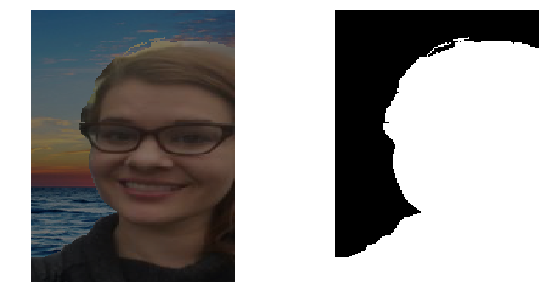

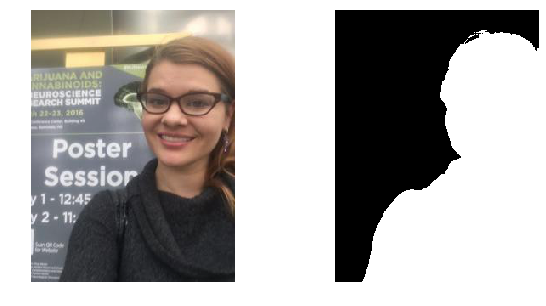

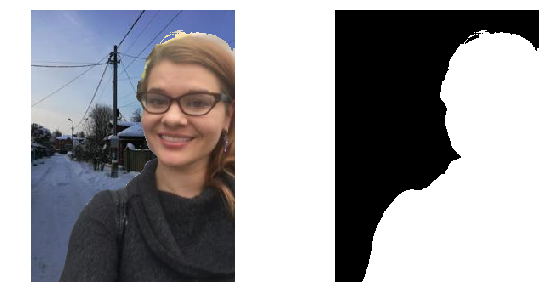

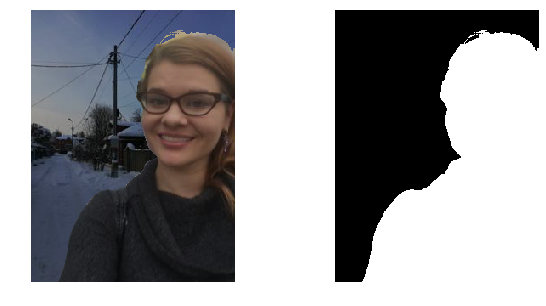

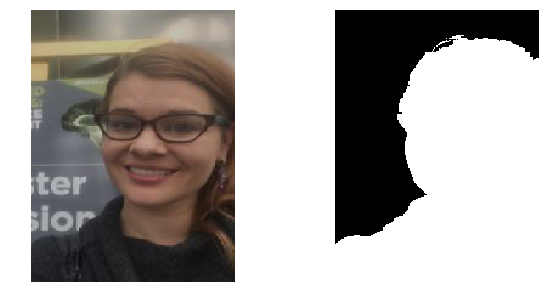

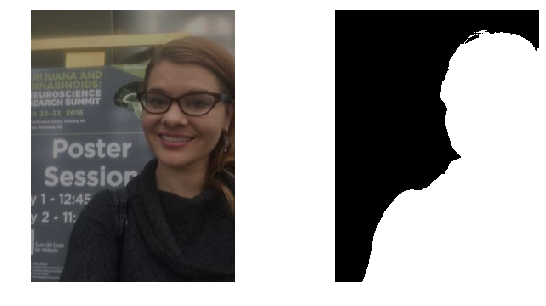

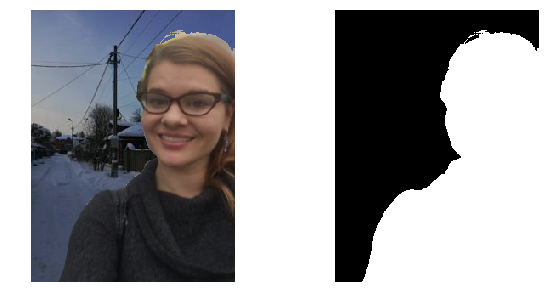

In [12]:
for i in range(7): 
    show_idx_image(dataset_show_transforms, 8)
plt.show()

Отобразите несколько изображений и масок, на которых будет видна правильная работа вашего модуля аугментации данных.

## Загрузчики

При обучении сети удобнее работать не с датасетами, а с загрузчиками. Загрузчики создаются на основе датасета и позволяют итерироваться по батчам из него.

Обратите внимание на параметры DataLoader. При num_workers > 1, батчи готовятся (загружаются картинки, обрабатываются и т.д.) сразу в нескольких фоновых процессах. С помощью параметра shuffle можно подавать картинки на обучение в случайном порядке.

## DiceLoss (1 балл)

Функция потерь реализовывается как и все стандартные нейронные модули в pytorch, через nn.Module. В ячейке ниже вам предлагается реализовать фукцию потерь dice (аналог меры Джаккарда).

Для ij-ого пикселя результата dice loss определим как:

$$
1 - \frac{2a_{ij}b_{ij}}{a_{ij} + b_{ij} + \varepsilon}
$$

где $a_{ij} \in [0, 1]$ — предсказанная вероятность нахождения человека в пикселе изображения, $b_{ij}$ — разметка для пикселя изображения.

DiceLoss для одного объекта — средний loss по всем пикселям.

In [0]:
class DiceLoss(nn.Module):
    def __init__(self, eps=1e-7, reduction='mean', mod=False, with_logits=True):
        """
        Arguments
        ---------
        eps : float
            eps in denominator
        reduction : string ('none', 'mean' or 'sum')
            specifies the reduction to apply to the output:
            
            'none': no reduction will be applied
            'mean': the sum of the output will be divided by the number of batches in the output
            'sum':  the output will be summed. 
        
        with_logits : bool
            If True, use additional sigmoid for inputs
        """
        super().__init__()
        self.eps = eps
        self.reduction = reduction
        self.with_logits = with_logits
        self.mod = mod
        
    def forward(self, logits, true_labels):
        true_labels = true_labels.float()
        
        if self.with_logits:
            logits = torch.sigmoid(logits)
        
        true_labels = torch.squeeze(true_labels, dim=(1))
        logits = torch.squeeze(logits, dim=(1))
        
        
        match_on_true = ((2*logits*true_labels).sum(dim=(1, 2)) / 
                         (logits+true_labels+self.eps).sum(dim=(1, 2)))
        dice_loss = 1 - match_on_true
        
        if self.mod:
            match_on_false = (2*((1-logits)*(1-true_labels)).sum(dim=(1, 2)) /
                              (2- (true_labels+logits+self.eps).sum(dim=(1, 2))))
            dice_loss -= match_on_false
        
        
        if self.reduction == 'sum':
            loss_value = torch.sum(dice_loss)
        elif self.reduction == 'mean':
            loss_value = torch.sum(dice_loss)/dice_loss.shape[0]
        else:
            loss_value = dice_loss
            
        return loss_value

Проверка реализации:

In [0]:
logits = torch.tensor([
    [[0, 0.5], [0.5, 1]],
    [[0.1, 0.1], [0, 0]],
])

target = torch.tensor([
    [[0, 1], [1, 1]],
    [[1, 0], [0, 1]],
])


losses = DiceLoss(with_logits=False, reduction=None, eps=1e-7)(logits, target)
npt.assert_almost_equal(losses.numpy(), np.array([0.2, 0.90909]), decimal=4)

loss = DiceLoss(with_logits=False, reduction='mean', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 0.554545, decimal=4)

loss = DiceLoss(with_logits=False, reduction='sum', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 1.10909, decimal=4)

## Unet (2 балла)

Для решения задачи сегментации будем использовать UNet с энкодером из первых блоков предобученного VGG13. Архитектура сети реализована за вас ниже.

Энкодер:

In [0]:
from torchvision.models import vgg13
import torch.optim as optim

In [0]:
class VGG13Encoder(torch.nn.Module):
    def __init__(self, num_blocks, pretrained=True):
        super().__init__()
        self.num_blocks = num_blocks
        self.blocks = nn.ModuleList()
        feature_extractor = vgg13(pretrained=pretrained).features
        for i in range(self.num_blocks):
            self.blocks.append(
                torch.nn.Sequential(*[feature_extractor[j]
                                      for j in range(i * 5, i * 5 + 4)]))

    def forward(self, x):
        activations = []
        for i in range(self.num_blocks):
            x = self.blocks[i](x)
            activations.append(x)
            if i != self.num_blocks - 1:
                x = torch.functional.F.max_pool2d(x, kernel_size=2, stride=2)
        return activations

Декодер:

In [0]:
class DecoderBlock(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.upconv = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv1 = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv2 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )

    def forward(self, down, left):
        x = torch.nn.functional.interpolate(down, scale_factor=2)
        x = self.upconv(x)
        x = self.conv1(torch.cat([left, x], 1))
        x = self.conv2(x)
        return x

In [0]:
class Decoder(nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        for i in range(num_blocks):
            self.add_module(f'block{num_blocks - i}', DecoderBlock(num_filters * 2**i))

    def forward(self, acts):
        up = acts[-1]
        for i, left in enumerate(acts[-2::-1]):
            up = self.__getattr__(f'block{i + 1}')(up, left)
        return up

Сеть Unet:

In [0]:
class UNet(torch.nn.Module):
    def __init__(self, num_classes=1, num_filters=64, num_blocks=4):
        super().__init__()
        self.encoder = VGG13Encoder(num_blocks=num_blocks)
        self.decoder = Decoder(num_filters=64, num_blocks=num_blocks - 1)
        self.final = torch.nn.Conv2d(
            in_channels=num_filters, out_channels=num_classes, kernel_size=1
        )

    def forward(self, x):
        acts = self.encoder(x)
        x = self.decoder(acts)
        x = self.final(x)
        return x

Функция для оценивания качества сети:

In [0]:
def evaluate_net(net, testloader, criterions, device='cpu'):
    net = net.eval()

    total = len(testloader)
    
    losses = [0 for elems in criterions]
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            
            images = images.to(device)
            
            outputs = net(images).to('cpu')
            for i, criterion in enumerate(criterions):
                losses[i] += float(criterion(outputs, labels).detach())
    
    
    res = [loss/total for loss in losses]
    
    return res

Теперь применим сеть на практике!

Обучите сеть на обучающей выборке и протестируйте качество на тестовой выборке.

Сначала при обучении используйте только кросс-энтропию (torch.nn.BCEWithLogitsLoss будет более удобна для бинарного случая). Зафиксируйте результат.

Сравните между собой несколько стратегий оптимизации (только кросс-энтропия, только dice loss, сумма двух лоссов с весами). Сделайте выводы.

In [0]:
def optimize_net(n_epochs, net, trainloader, optimizer, criterion, add_measure=None,
                 use_cuda=True, verbose=True, n_batches_for_verbose=0):
    
    net = net.train()
    
    n_batches=len(trainloader)
    if n_batches_for_verbose==0:
        n_batches_for_verbose = n_batches/2 + 1
    
    # loop over the dataset multiple times
    running_loss = 0.0
    add_loss = 0.0
            
    for epoch in range(n_epochs):  
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            
            if use_cuda:
                inputs = inputs.cuda()
                labels = labels.cuda()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            
            if add_measure is not None:
                add_loss += float(add_measure(outputs, labels))
                #print(add_loss)
                  
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += float(loss)

            # print every 6000 mini-batches
            if verbose:
                if i % n_batches_for_verbose == 0:
                    epoch_value = np.around(i / n_batches, 2) + epoch
                    
                    str_verbose = '[{:.2f}] loss: {:.4f} '\
                        .format(epoch_value, running_loss / n_batches_for_verbose)
                    
                    if add_measure is not None:
                        str_verbose += 'add_measure: {:.4f}'.format(add_loss / n_batches_for_verbose)
                    
                    print(str_verbose)
                    add_loss = running_loss = 0.0
                                      
    if verbose:
        print('Finished Training')

In [0]:
class SumMeasures(nn.Module):
    def __init__(self, loss_1, loss_2, coef_1):
        super().__init__()
        self.loss_1 = loss_1
        self.loss_2 = loss_2
        
        if coef_1 > 1 or coef_1 < 0:
            raise ValueError
        self.coef_1 = coef_1
        
        
        
    def forward(self, predict, labels):        
        res = (self.coef_1 * self.loss_1(predict, labels) + 
               (1-self.coef_1)*self.loss_2(predict, labels))
        return res

In [0]:
batch_size = 8
train_data_loader = DataLoader(train_dataset, 
                               batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size)

In [22]:
net_dice_17_SGD = UNet()
net_dice_mod_17_SGD = UNet()
net_entropy_10_Adam = UNet()
net_entropy_plus_dice_1_12_SGD = UNet()
net_entropy_plus_dice_2_12_SGD = UNet()

Downloading: "https://download.pytorch.org/models/vgg13-c768596a.pth" to /root/.torch/models/vgg13-c768596a.pth
532194478it [00:05, 89755953.96it/s]


In [0]:
cross_entropy = nn.BCEWithLogitsLoss()
dice_loss = DiceLoss()


In [25]:
my_net = net_entropy_10_Adam.cuda()
num_epoch = 10
optimizer = optim.Adam(my_net.parameters(), lr=1e-3, weight_decay=1e-5)
info_net_entropy_10_Adam = optimize_net(
    num_epoch, my_net, train_data_loader, 
    optimizer, criterion=cross_entropy, add_measure=dice_loss,
    use_cuda=True, verbose=True, n_batches_for_verbose=87
)

[0.00] loss: 0.0082 add_measure: 0.0051
[0.51] loss: 0.8198 add_measure: 0.3537
[1.00] loss: 0.5066 add_measure: 0.2877
[1.51] loss: 0.4786 add_measure: 0.2717
[2.00] loss: 0.3808 add_measure: 0.2163
[2.51] loss: 0.3875 add_measure: 0.2177
[3.00] loss: 0.3322 add_measure: 0.1845
[3.51] loss: 0.3520 add_measure: 0.1985
[4.00] loss: 0.2729 add_measure: 0.1496
[4.51] loss: 0.2528 add_measure: 0.1395
[5.00] loss: 0.2303 add_measure: 0.1285
[5.51] loss: 0.2417 add_measure: 0.1305
[6.00] loss: 0.2234 add_measure: 0.1242
[6.51] loss: 0.2072 add_measure: 0.1139
[7.00] loss: 0.2377 add_measure: 0.1314
[7.51] loss: 0.2286 add_measure: 0.1236
[8.00] loss: 0.2074 add_measure: 0.1135
[8.51] loss: 0.1885 add_measure: 0.1006
[9.00] loss: 0.1974 add_measure: 0.1079
[9.51] loss: 0.1897 add_measure: 0.1015
Finished Training


In [29]:
evaluate_net(net_entropy_10_Adam, test_data_loader, [cross_entropy, dice_loss], 'cuda')

[0.21585843712091446, 0.12167726581295331]

In [0]:
batch_size = 12
train_data_loader = DataLoader(train_dataset, 
                               batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size)

In [38]:
my_net = net_dice_17_SGD.cuda()
num_eopchs=17
optimizer = optim.SGD(my_net.parameters(), lr=4*1e-3, momentum=0.8)
info_net_dice_17_SGD = optimize_net(
    num_eopchs, my_net, train_data_loader, 
    optimizer, criterion=dice_loss, add_measure=cross_entropy,
    use_cuda=True, verbose=True, n_batches_for_verbose=0
)

[0.00] loss: 0.0008 add_measure: 0.0115
[1.00] loss: 0.1422 add_measure: 2.3171
[2.00] loss: 0.1414 add_measure: 2.5132
[3.00] loss: 0.1321 add_measure: 2.4850
[4.00] loss: 0.1273 add_measure: 2.5775
[5.00] loss: 0.1281 add_measure: 2.6506
[6.00] loss: 0.1287 add_measure: 2.7906
[7.00] loss: 0.1239 add_measure: 2.7596
[8.00] loss: 0.1203 add_measure: 2.7910
[9.00] loss: 0.1149 add_measure: 2.5553
[10.00] loss: 0.1167 add_measure: 2.7427
[11.00] loss: 0.1157 add_measure: 2.8001
[12.00] loss: 0.1123 add_measure: 2.6672
[13.00] loss: 0.1094 add_measure: 2.7043
[14.00] loss: 0.1099 add_measure: 2.6885
[15.00] loss: 0.1092 add_measure: 2.6914
[16.00] loss: 0.1100 add_measure: 2.6632
Finished Training


In [36]:
my_net = net_entropy_plus_dice_1_12_SGD.cuda()
num_eopchs=12
criterion = SumMeasures(cross_entropy, dice_loss, 0.7)
optimizer = optim.SGD(my_net.parameters(), lr=4*1e-3, momentum=0.8)
info_net_dice_12_SGD = optimize_net(
    num_eopchs, my_net, train_data_loader, 
    optimizer, criterion=criterion, add_measure=cross_entropy,
    use_cuda=True, verbose=True, n_batches_for_verbose=0
)

[0.00] loss: 0.0109 add_measure: 0.0121
[1.00] loss: 0.8622 add_measure: 0.9932
[2.00] loss: 0.4213 add_measure: 0.4930
[3.00] loss: 0.3537 add_measure: 0.4140
[4.00] loss: 0.3248 add_measure: 0.3808
[5.00] loss: 0.3153 add_measure: 0.3693
[6.00] loss: 0.2928 add_measure: 0.3432
[7.00] loss: 0.2911 add_measure: 0.3405
[8.00] loss: 0.2775 add_measure: 0.3249
[9.00] loss: 0.2724 add_measure: 0.3194
[10.00] loss: 0.2639 add_measure: 0.3103
[11.00] loss: 0.2531 add_measure: 0.2967
Finished Training


In [45]:
net_entropy_plus_dice_2_15_SGD = UNet()
my_net = net_entropy_plus_dice_2_15_SGD.cuda()
num_eopchs=15
criterion = SumMeasures(cross_entropy, dice_loss, 0.6)
optimizer = optim.SGD(my_net.parameters(), lr=4*1e-3, momentum=0.8)
info = optimize_net(
    num_eopchs, my_net, train_data_loader, 
    optimizer, criterion=criterion, add_measure=cross_entropy,
    use_cuda=True, verbose=True, n_batches_for_verbose=0
)

[0.00] loss: 0.0109 add_measure: 0.0125
[1.00] loss: 0.8495 add_measure: 1.0303
[2.00] loss: 0.4060 add_measure: 0.5065
[3.00] loss: 0.3355 add_measure: 0.4201
[4.00] loss: 0.3125 add_measure: 0.3907
[5.00] loss: 0.2928 add_measure: 0.3665
[6.00] loss: 0.2861 add_measure: 0.3583
[7.00] loss: 0.2779 add_measure: 0.3481
[8.00] loss: 0.2736 add_measure: 0.3418
[9.00] loss: 0.2560 add_measure: 0.3218
[10.00] loss: 0.2548 add_measure: 0.3201
[11.00] loss: 0.2447 add_measure: 0.3066
[12.00] loss: 0.2432 add_measure: 0.3047
[13.00] loss: 0.2384 add_measure: 0.2985
[14.00] loss: 0.2290 add_measure: 0.2857
Finished Training


In [0]:
net_only_work = UNet().cuda()
my_net = net_only_work
optimizer = optim.Adam(my_net.parameters(), lr=1e-3, weight_decay=1e-4)
nth = optimize_net(
    70, my_net, train_data_loader, 
    optimizer, criterion=cross_entropy, add_measure=dice_loss,
    use_cuda=True, verbose=True
)

[0.00] loss: 0.0117 add_measure: 0.0073
[1.00] loss: 1.5191 add_measure: 0.7271
[2.00] loss: 0.9648 add_measure: 0.5400
[3.00] loss: 0.7055 add_measure: 0.3983
[4.00] loss: 0.6091 add_measure: 0.3429
[5.00] loss: 0.4911 add_measure: 0.2681
[6.00] loss: 0.4623 add_measure: 0.2547
[7.00] loss: 0.4337 add_measure: 0.2391
[8.00] loss: 0.3992 add_measure: 0.2175


In [0]:
def get_i_output(my_net, loader, i):
    my_net = my_net.eval()
    my_net = my_net.cpu()
    for j, data in enumerate(loader):
        if j < i:
            continue
        with torch.no_grad():
            res1 = torch.sigmoid(my_net(data[0]))
        break
    return res1
        
def show_2_masks(net_res, target):

    net_res = net_res.squeeze().numpy()
    target = target.squeeze().numpy()
    
    
    fig, ax = plt.subplots(1, 3)
    fig.set_figwidth(8)
    fig.set_figheight(3)

    
    plt.style.use('default')
    plt.subplot(1, 2, 1)
    plt.title('Real mask')
    plt.imshow(target, cmap='gray')
    plt.xticks([], [])
    plt.yticks([], [])
 
    
    plt.subplot(1, 2, 2)
    plt.title('Predicted mask')
    plt.imshow(net_res, cmap='gray')
    plt.xticks([], [])
    plt.yticks([], [])

test_dataset_show = PhotosDataset(
    images_dir=DATA_PATH + 'test/',
    target_dir=DATA_PATH + 'test_mask/',
    _transforms= transforms_photo,
    probability_transform = 0
)
test_data_show_loader = DataLoader(test_dataset_show, batch_size=1)

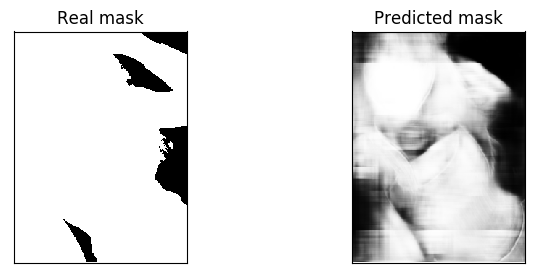

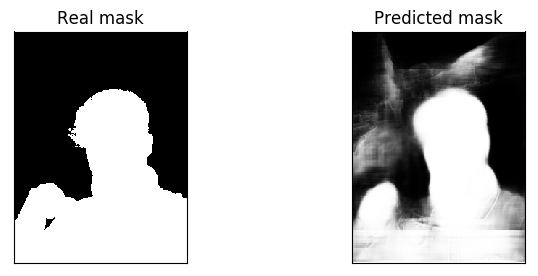

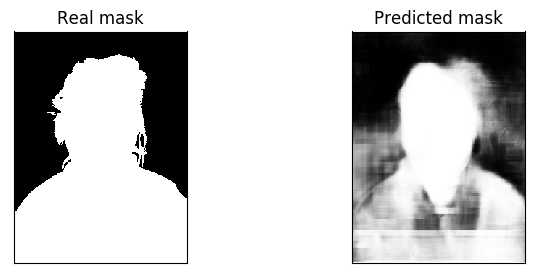

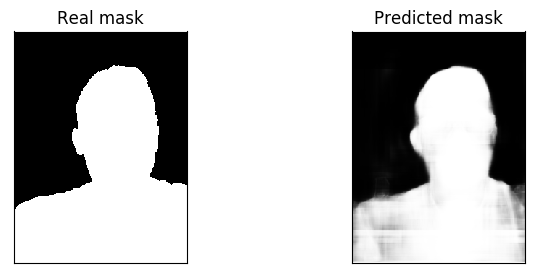

In [34]:
number_pic = 40
res1 = get_i_output(net_entropy_10_Adam, test_data_show_loader, number_pic)
show_2_masks(res1, test_dataset_show[number_pic][1])

number_pic = 50
res1 = get_i_output(net_entropy_10_Adam, test_data_show_loader, number_pic)
show_2_masks(res1, test_dataset_show[number_pic][1])

number_pic = 60
res1 = get_i_output(net_entropy_10_Adam, test_data_show_loader, number_pic)
show_2_masks(res1, test_dataset_show[number_pic][1])

number_pic = 70
res1 = get_i_output(net_entropy_10_Adam, test_data_show_loader, number_pic)
show_2_masks(res1, test_dataset_show[number_pic][1])

plt.show()

In [39]:
evaluate_net(net_dice_17_SGD, test_data_loader, [cross_entropy, dice_loss], 'cuda')

[1.4904825190703075, 0.055192462944736086]

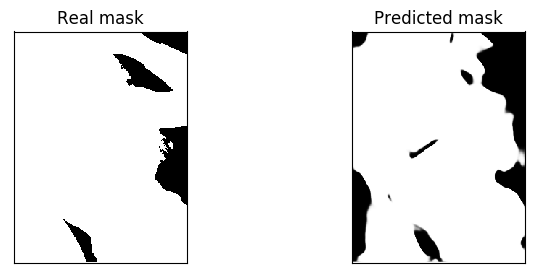

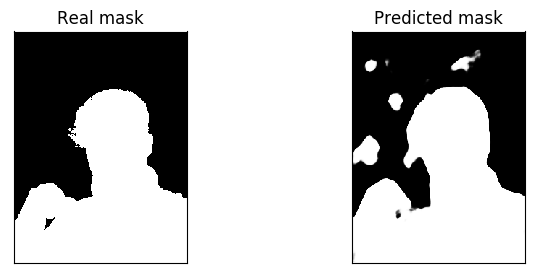

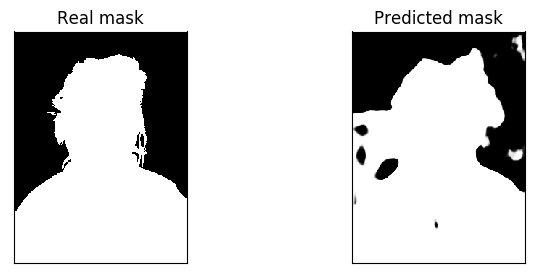

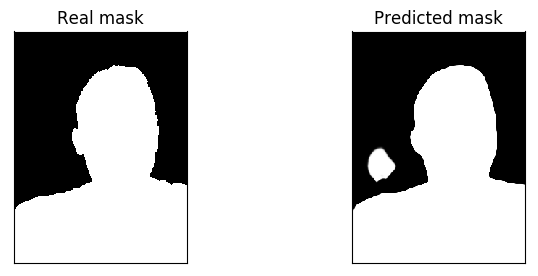

In [40]:

my_net = net_dice_17_SGD
number_pic = 40
res1 = get_i_output(my_net, test_data_show_loader, number_pic)
show_2_masks(res1, test_dataset_show[number_pic][1])

number_pic = 50
res1 = get_i_output(my_net, test_data_show_loader, number_pic)
show_2_masks(res1, test_dataset_show[number_pic][1])

number_pic = 60
res1 = get_i_output(my_net, test_data_show_loader, number_pic)
show_2_masks(res1, test_dataset_show[number_pic][1])

number_pic = 70
res1 = get_i_output(my_net, test_data_show_loader, number_pic)
show_2_masks(res1, test_dataset_show[number_pic][1])

plt.show()

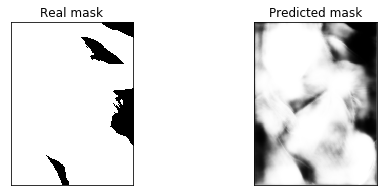

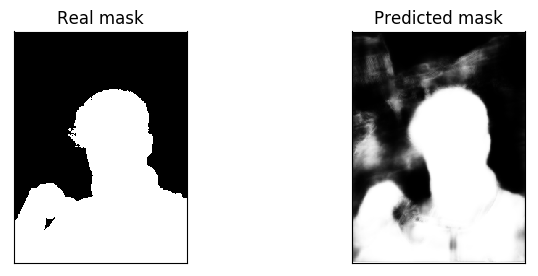

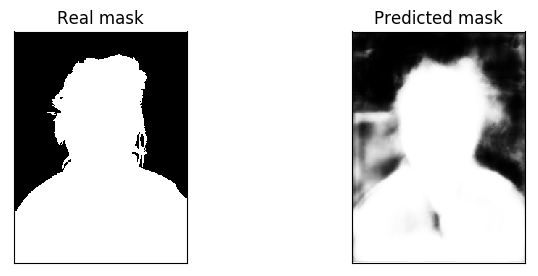

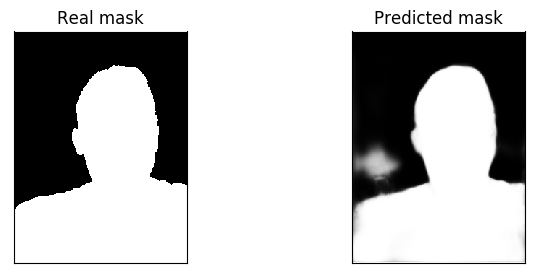

In [40]:
my_net = net_entropy_plus_dice_1_12_SGD
number_pic = 40
res1 = get_i_output(my_net, test_data_show_loader, number_pic)
show_2_masks(res1, test_dataset_show[number_pic][1])

number_pic = 50
res1 = get_i_output(my_net, test_data_show_loader, number_pic)
show_2_masks(res1, test_dataset_show[number_pic][1])

number_pic = 60
res1 = get_i_output(my_net, test_data_show_loader, number_pic)
show_2_masks(res1, test_dataset_show[number_pic][1])

number_pic = 70
res1 = get_i_output(my_net, test_data_show_loader, number_pic)
show_2_masks(res1, test_dataset_show[number_pic][1])

plt.show()

In [43]:
net_entropy_plus_dice_1_12_SGD.cuda()
evaluate_net(net_entropy_plus_dice_1_12_SGD, test_data_loader,
             [criterion, cross_entropy, dice_loss], 'cuda')



[0.13112344654897848, 0.15675474951664606, 0.07131706457585096]

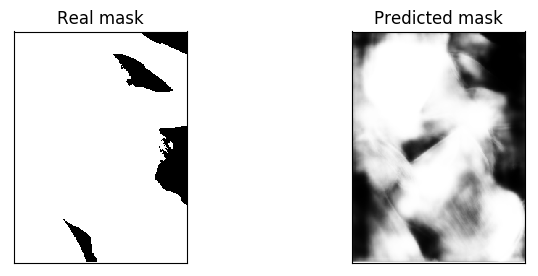

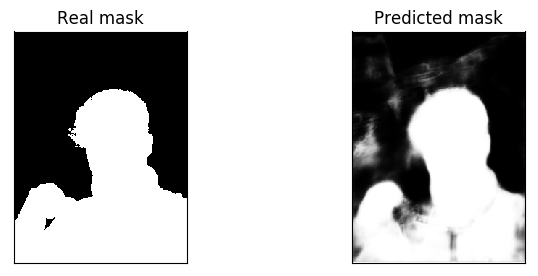

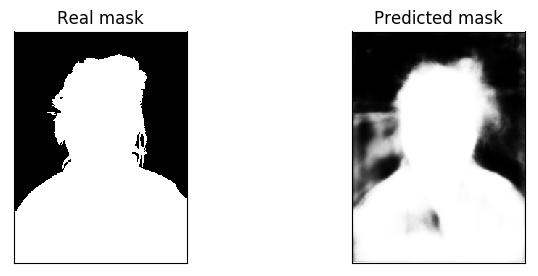

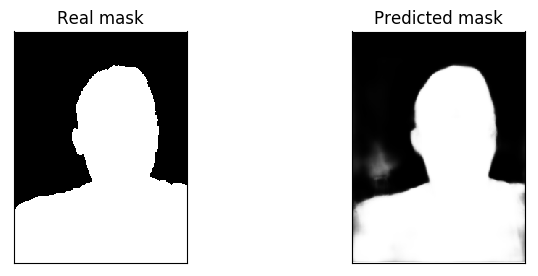

In [46]:
my_net = net_entropy_plus_dice_2_15_SGD
number_pic = 40
res1 = get_i_output(my_net, test_data_show_loader, number_pic)
show_2_masks(res1, test_dataset_show[number_pic][1])

number_pic = 50
res1 = get_i_output(my_net, test_data_show_loader, number_pic)
show_2_masks(res1, test_dataset_show[number_pic][1])

number_pic = 60
res1 = get_i_output(my_net, test_data_show_loader, number_pic)
show_2_masks(res1, test_dataset_show[number_pic][1])

number_pic = 70
res1 = get_i_output(my_net, test_data_show_loader, number_pic)
show_2_masks(res1, test_dataset_show[number_pic][1])

plt.show()

In [47]:
net_entropy_plus_dice_2_15_SGD.cuda()
evaluate_net(net_entropy_plus_dice_1_12_SGD, test_data_loader,
             [criterion, cross_entropy, dice_loss], 'cuda')


[0.12650010424355665, 0.16130120617647967, 0.0742984414100647]

## LinkNet (3 балла)

Реализуйте архитектуру LinkNet с использованием энкодера, основанного на VGG13. Архитектура похожа на Unet, но вместо конкатенации слоёв используются skip-connections. Для реализации достаточно переписать структуру декодировщика из предыдущего пункта.

https://arxiv.org/pdf/1707.03718.pdf

In [0]:
# your code here

Обучите LinkNet. Сравните LinkNet и Unet по качеству и скорости работы. Сделайте выводы. 

## Бонус: постобработка изображений (1 балл)

В предложенной задаче на фотографиях необходимо сегментировать только центральное изображения. Артефакты, которые появляются на краях изображения, можно удалять с помощью постобработки (например, с помощью модуля https://scikit-image.org/docs/dev/api/skimage.morphology.html). 

Реализуйте какой-нибудь из методов постобработки, дающий прирост в качестве. Продемонстируйте несколько изображений, на которых постобработка будет оказывать влияние на результат сегментации.

## Бонус: существенное улучшение качества (2 балла)

Придумайте какой-нибудь трюк, который существенно (с учётом бонусного пункта 1) повысит качество (которое должно быть и так достаточно высоко). Не разрешается использовать дополнительные данные или другие предобученные кодировщики кроме VGG13.

Если вы что-то попробовали, но качество не повысилось, всё равно оформите этот пункт, даже за неудачные попытки могут быть начислены баллы.